In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [14]:
import os
PathToRepo = os.path.normpath(os.getcwd() + os.sep + os.pardir)
Df = pd.read_csv(PathToRepo + '\\Data\\Faellesdata_cleaned.csv')

In [15]:
x_train, x_test, y_train, y_test = train_test_split(Df.drop('IsMigratorInt', axis=1), Df['IsMigratorInt'], test_size=0.2, random_state=42)

In [16]:
import statsmodels.api as sm
import time
import itertools
from ISLP.models import (ModelSpec as MS,
                         summarize, poly)

In [17]:
#Make dataframe thats called DataFinal that has x_train and y_train
DataFinal = x_train
DataFinal['IsMigratorInt'] = y_train


In [18]:
DataFinalTest = x_test
DataFinalTest['IsMigratorInt'] = y_test

In [19]:
# Found on google
def processSubset(feature_set):
    # Fit model on feature_set and calculate Cross entropy
    X = MS(list(feature_set)).fit_transform(DataFinal[list(feature_set)])
    model = sm.GLM(
        DataFinal["IsMigratorInt"]
        , X
        , family = sm.families.Binomial()
        )
    regr = model.fit()
    
    maskIsMigrator = y_test == 1
    maskIsNotMigrator = y_test == 0
    predictions = regr.predict(sm.add_constant(DataFinalTest[list(feature_set)]))
    
    CrossEntropy = np.mean(
        y_test[maskIsMigrator]*np.log(predictions[maskIsMigrator])
        ) + np.mean(
            (y_test[maskIsNotMigrator])*np.log(1-predictions[maskIsNotMigrator])
            )
    return {"model": regr, "CrossEntropy": CrossEntropy}

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(DataFinal.iloc[:,:-2], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['CrossEntropy'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [20]:
import pickle

In [21]:
# # Takes 6.30 to run on my machine, just load with pickle in cell below if you don't want to wait
# models_best = pd.DataFrame(columns=["model", "CrossEntropy"])

# tic = time.time()
# for i in range(len(DataFinal.iloc[:,:-1].columns)):
#     models_best.loc[i] = getBest(i)
 
# toc = time.time()
# print("Total elapsed time:", (toc-tic), "seconds.")

# pickle.dump(models_best, open("models_best.p", "wb"))

In [22]:
models_best = pickle.load(open("models_best.p", "rb"))

In [23]:
Outcome = models_best.apply(lambda row: row["model"].params, axis=1) # get the parameters of the best model for each number of predictors
Outcome = pd.DataFrame(Outcome)
Outcome.to_csv('OutcomeBestSubsetSelection.csv')
Outcome.to_latex(PathToRepo + '\\Tables\\OutcomeBestSubsetSelection.tex', float_format="%.2f", caption="Best subset selection results for k predictors", label="tab:BestSubset", position="h!")
Outcome

,Rcyl,age,cfe,ch,feh,intercept,mass,mgh,ofe,oh,phi,vRcyl,vphi,vz,z
0,NaN,NaN,NaN,NaN,NaN,-1.531514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.480334,NaN,NaN,NaN,NaN,-3.091869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.499571,NaN,-5.190512,NaN,NaN,-1.546326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.477985,NaN,NaN,-1.202143,NaN,-3.574241,NaN,NaN,NaN,NaN,NaN,NaN,0.003813,NaN,NaN
4,0.461851,NaN,-8.166532,NaN,NaN,-6.121112,NaN,NaN,10.880721,NaN,NaN,NaN,0.003726,NaN,NaN
5,0.395465,-0.340060,NaN,-13.688766,NaN,-0.876166,NaN,12.861914,NaN,NaN,NaN,NaN,0.002984,NaN,NaN
6,0.387975,-0.432730,NaN,-12.213558,NaN,1.415734,NaN,20.082715,NaN,-9.156160,NaN,NaN,0.002861,NaN,NaN
7,0.385616,-0.442503,7.088396,-16.668364,NaN,-0.468258,NaN,24.659167,NaN,-9.323452,NaN,NaN,0.002897,NaN,NaN
8,0.385465,-0.442967,7.128256,-16.679731,NaN,-0.472790,NaN,24.685921,NaN,-9.343527,NaN,NaN,0.002894,NaN,0.098556
9,0.386470,-0.443371,7.187394,-16.674037,NaN,-0.481581,NaN,24.720311,NaN,-9.387370,NaN,NaN,0.002872,-0.000853,0.089196


In [24]:
models_best['CrossEntropy'].to_csv('CrossEntropy.csv')
models_best['CrossEntropy']

0    -1.727252
1    -1.302324
2    -1.268073
3    -1.189581
4    -1.184552
5    -1.176439
6    -1.173193
7    -1.170875
8    -1.169733
9    -1.168913
10   -1.168484
11   -1.168135
12   -1.168609
13   -1.170306
14   -1.173312
Name: CrossEntropy, dtype: object

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
bic = models_best.apply(lambda row: row["model"].bic_llf, axis=1) # get the BIC of the best model for each number of predictors
aic = models_best.apply(lambda row: row["model"].aic, axis=1) # get the Mallow's Cp of the best model for each number of predictors

def Accuracy(row):
    indecies = [item for item in list(row["model"].params.index) if item != 'intercept']
    predictions = row["model"].predict(sm.add_constant(x_test[indecies]))
    return accuracy_score(y_test, predictions > 0.5)

AccuracyTestData = models_best.apply(Accuracy, axis=1)

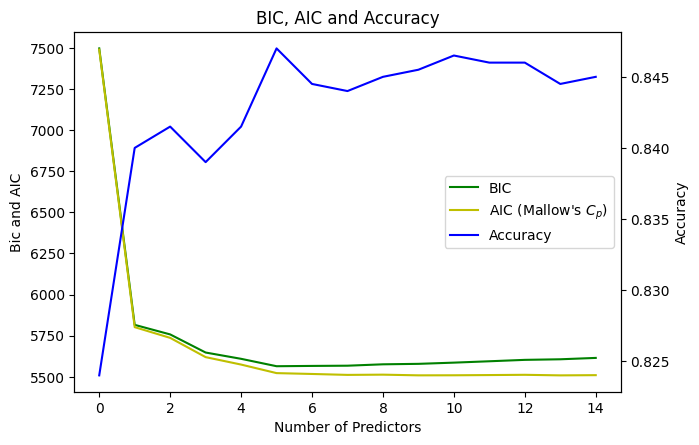

In [27]:
fig, ax1 = plt.subplots(figsize=(7, 5))

fig.tight_layout(pad=4.0)

ax2 = ax1.twinx()
BicPlot, = ax1.plot(bic, 'g-', label = "BIC")
AicPlot, = ax1.plot(aic, 'y-', label = "AIC (Mallow's $C_p$)")
AccuracyPlot, = ax2.plot(AccuracyTestData, 'b-', label="Accuracy")

plt.legend([BicPlot, AicPlot, AccuracyPlot], ['BIC', 'AIC (Mallow\'s $C_p$)', 'Accuracy'], loc = 'center right')

ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('Bic and AIC')
ax2.set_ylabel('Accuracy')
plt.title("BIC, AIC and Accuracy")
plt.savefig(PathToRepo + '\\Plots\\BicAicAccuracy.png')

In [28]:
print(bic.idxmin()) #Finds where minimum  and maximum values are
print(aic.idxmin())
print(AccuracyTestData.idxmax())

5
13
5


In [45]:
model = models_best['model'].iloc[5]
summary = model.summary()
 
# Display and interpret results
with open(PathToRepo + '\\Tables\\GLMbestsubset.tex', 'w') as f:
    f.write(summary.as_latex())

#accuracy
pred = model.predict(sm.add_constant(x_test[model.params.index[1:]]))
print(accuracy_score(y_test, pred > 0.5))

summary

0.847


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          IsMigratorInt   No. Observations:                 7999
Model:                            GLM   Df Residuals:                     7993
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2755.3
Date:                Thu, 12 Dec 2024   Deviance:                       5510.6
Time:                        21:59:20   Pearson chi2:                 7.74e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2189
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.8762      0.331     -2.648      0.008      -1.525      -0.228
Rcyl           0.3955      0.017     22.912      0.000       0.362       0.429
vphi           0.0030      0.000      8.522      0.000       0.002       0.004
age           -0.3401      0.043     -7.820      0.000      -0.425      -0.255
ch           -13.6888      1.293    -10.589      0.000     -16.222     -11.155
mgh           12.8619      1.380      9.321      0.000      10.157      15.566
==============================================================================
"""